In [1]:
import glob
futureList = glob.glob('C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet/*.parquet')
print(futureList)

import pandas as pd

df_fut = pd.read_parquet(futureList[0])

for future_file in futureList[1:]:
    df_future = pd.read_parquet(future_file)
    
    df_fut = pd.concat([df_fut, df_future], axis=0, ignore_index=True)


# 檢查結果
# print(df_opt.info())
print(df_fut.columns)


df_opt = pd.read_parquet("C:/my_file/0_research/20250908_FutureStrategy/option_data/processed_parquet/opt_all.parquet")
df_opt = df_opt.drop(columns=['漲跌價', '漲跌%', 'Unnamed: 20', '契約到期日', 'Unnamed: 21'])
print(df_opt.columns)



['C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2001_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2002_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2003_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2004_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2005_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2006_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2007_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2008_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2009_fut.parquet', 'C:/my_file/0_research/20250908_FutureStrategy/future_data/processed_parquet\\2010_fut.parquet', 'C:/my_file/0_research/202509

In [2]:
import pandas as pd
import numpy as np

def clean_numeric_col(series):
    """
    輔助函式：清洗含有逗號的數字字串，並處理 '-' 為 NaN
    """
    return pd.to_numeric(
        series.astype(str).str.replace(',', '').str.strip().replace('-', np.nan), 
        errors='coerce'
    )

def clean_futures_data(df_raw):
    """
    清洗期貨資料
    1. 轉換日期格式
    2. 排除價差單 (含有 '/' 的合約)
    3. 轉換價格欄位為浮點數
    """
    print("--- 開始清洗期貨資料 (Futures) ---")
    df = df_raw.copy()
    
    # 1. 日期標準化
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    
    # 2. 排除價差單 (Spread Orders)
    # 檢查 '到期月份(週別)' 和 '契約' 是否含有 '/'
    mask_spread_month = df['到期月份(週別)'].astype(str).str.contains('/')
    mask_spread_contract = df['契約'].astype(str).str.contains('/')
    
    before_len = len(df)
    df = df[~(mask_spread_month | mask_spread_contract)]
    after_len = len(df)
    print(f">> 已排除價差單: {before_len - after_len} 筆")

    # 3. 數值欄位清洗 (去除逗號, 轉 float)
    target_cols = ['開盤價', '最高價', '最低價', '收盤價', '結算價']
    for col in target_cols:
        if col in df.columns:
            df[col] = clean_numeric_col(df[col])
            
    # 4. 排序與重設索引
    df.sort_values(by=['交易日期', '契約', '到期月份(週別)'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print(f">> 期貨資料清洗完成，共 {len(df)} 筆。")
    return df

def clean_options_data(df_raw):
    """
    清洗選擇權資料
    1. 過濾非一般交易時段
    2. 轉換日期與履約價格式
    3. 轉換價格欄位
    """
    print("--- 開始清洗選擇權資料 (Options) ---")
    df = df_raw.copy()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()
    
    # 1. 過濾交易時段 (只留 '一般')
    if '交易時段' in df.columns:
        before_len = len(df)
        df = df[df['交易時段'] == '一般']
        print(f">> 已過濾盤後資料: {before_len - len(df)} 筆")
    
    # 2. 日期標準化
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    
    # 3. 履約價轉數值 (重要：用於排序與查找)
    df['履約價'] = clean_numeric_col(df['履約價'])
    
    # 4. 價格欄位清洗
    target_cols = ['開盤價', '最高價', '最低價', '收盤價', '結算價']
    for col in target_cols:
        if col in df.columns:
            df[col] = clean_numeric_col(df[col])
            
    # 5. 確保到期月份格式乾淨 (去除空格)
    df['到期月份(週別)'] = df['到期月份(週別)'].astype(str).str.strip()

    # 6. 排序
    # 注意：履約價排序對於尋找價差組合(Spread)很重要
    df.sort_values(by=['交易日期', '到期月份(週別)', '履約價'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print(f">> 選擇權資料清洗完成，共 {len(df)} 筆。")
    return df

# ==========================================
# 執行清洗 (假設 df_fut 和 df_opt 已經讀入)
# ==========================================
# 為了避免變數名稱衝突，建議使用 _clean 後綴
df_fut_clean = clean_futures_data(df_fut)
df_opt_clean = clean_options_data(df_opt)

# 簡單檢查一下結果
print("\n[檢查] 期貨資料前 3 筆:")
print(df_fut_clean[['交易日期', '契約', '到期月份(週別)', '開盤價', '收盤價']].head(3))

print("\n[檢查] 選擇權資料前 3 筆:")
print(df_opt_clean[['交易日期', '到期月份(週別)', '履約價', '買賣權', '收盤價']].head(3))

--- 開始清洗期貨資料 (Futures) ---
>> 已排除價差單: 36798 筆
>> 期貨資料清洗完成，共 44990 筆。
--- 開始清洗選擇權資料 (Options) ---
>> 已過濾盤後資料: 2317932 筆
>> 選擇權資料清洗完成，共 1529628 筆。

[檢查] 期貨資料前 3 筆:
        交易日期  契約 到期月份(週別)     開盤價     收盤價
0 2001-01-02  TX   200101  4702.0  4892.0
1 2001-01-02  TX   200102  4750.0  4909.0
2 2001-01-02  TX   200103  4724.0  4950.0

[檢查] 選擇權資料前 3 筆:
        交易日期 到期月份(週別)     履約價 買賣權  收盤價
0 2017-01-03   201701  7500.0  買權  0.0
1 2017-01-03   201701  7500.0  賣權  0.1
2 2017-01-03   201701  7600.0  買權  0.0


In [3]:
df_fut_clean

,交易日期,契約,到期月份(週別),開盤價,最高價,最低價,收盤價,漲跌價,漲跌%,成交量,結算價,未沖銷契約數,最後最佳買價,最後最佳賣價,歷史最高價,歷史最低價,是否因訊息面暫停交易,交易時段,價差對單式委託成交量
0,2001-01-02,TX,200101,4702.0,4948.0,4685.0,4892.0,122,2.56%,14824,4892.0,6699,4892.0,4893.0,5612,4561,NaN,NaN,NaN
1,2001-01-02,TX,200102,4750.0,4948.0,4666.0,4909.0,174,3.67%,102,4909.0,129,4890.0,4910.0,4948,4570,NaN,NaN,NaN
2,2001-01-02,TX,200103,4724.0,4950.0,4724.0,4950.0,112,2.32%,4,4919.0,34,4808.0,5030.0,9500,4635,NaN,NaN,NaN
3,2001-01-02,TX,200106,5030.0,5030.0,4900.0,4901.0,153,3.22%,4,4901.0,21,4900.0,4977.0,8700,4680,NaN,NaN,NaN
4,2001-01-02,TX,200109,0.0,0.0,0.0,0.0,-,-,0,4988.0,0,0.0,0.0,4953,4780,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44985,2026-01-16,TX,202606,31470.0,31700.0,31462.0,31700.0,355,1.13%,45,0.0,0,31550.0,31641.0,31700,20819,None,盤後,None
44986,2026-01-16,TX,202609,31400.0,31560.0,31273.0,31514.0,370,1.19%,15,31527.0,200,31510.0,31544.0,31560,24962,None,一般,None
44987,2026-01-16,TX,202609,31294.0,31500.0,31260.0,31500.0,356,1.14%,14,0.0,0,31323.0,31436.0,31500,24962,None,盤後,None
44988,2026-01-16,TX,202612,31502.0,31670.0,31370.0,31615.0,353,1.13%,12,31634.0,66,31609.0,31659.0,31670,27382,None,一般,None


In [4]:
import pandas as pd
import numpy as np

def get_target_contract_price(df_fut_clean, date, contract_month):
    """
    取得特定日期、特定合約月份的期貨價格。
    
    參數:
        df_fut_clean (pd.DataFrame): 經過 clean_futures_data 清洗後的期貨資料表。
        date (pd.Timestamp or str): 查詢日期。
        contract_month (str): 目標合約月份 (e.g., '202205')。
        
    回傳:
        float: 該合約當日的價格 (優先順序: 開盤價 > 收盤價 > 結算價)。
        None: 若查無資料。
    """
    
    # 1. 確保日期格式一致
    target_date = pd.to_datetime(date)
    
    # 2. 確保合約月份格式一致 (去除空白, 轉字串)
    target_month = str(contract_month).strip()
    
    # 3. 篩選日期 (利用 Boolean Mask)
    # 註：若資料量極大，可考慮將交易日期設為 Index 以加速，但此處維持通用性
    day_data = df_fut_clean[df_fut_clean['交易日期'] == target_date].copy()
    
    if day_data.empty:
        print(f">> 查無 {target_date.date()} 的期貨資料。")
        return None
        
    # 4. 篩選合約月份
    day_data['到期月份(週別)'] = day_data['到期月份(週別)'].str.strip()
    contract_data = day_data[day_data['到期月份(週別)'] == target_month]
    del day_data  # 釋放記憶體
    
    if contract_data.empty:
        print(f">> 查無 {target_date.date()} 的 {target_month} 合約資料。")
        return None
        
    # 5. 取得第一筆資料 (理論上清洗後同一天同一合約只會有一筆)
    row = contract_data.iloc[0]
    
    # 6. 價格選取邏輯 (Open > Close > Settlement)
    price = np.nan
    
    # 嘗試取得開盤價
    if '開盤價' in row and pd.notna(row['開盤價']) and row['開盤價'] > 0:
        price = row['開盤價']
    # Fallback: 收盤價
    elif '收盤價' in row and pd.notna(row['收盤價']) and row['收盤價'] > 0:
        price = row['收盤價']
    # Fallback: 結算價 (處理無成交量但有結算價的情況)
    elif '結算價' in row and pd.notna(row['結算價']) and row['結算價'] > 0:
        price = row['結算價']
        
    # 7. 回傳結果
    if pd.isna(price) or price <= 0:
        print(f">> {target_date.date()} 的 {target_month} 合約無有效價格資料。")
        return None
    
    return float(price)

# ==========================================
# 測試範例
# ==========================================
# 假設 df_fut_clean 已經存在
target_date = pd.Timestamp('2020-11-17')
contract = '202101'
price = get_target_contract_price(df_fut_clean, target_date, contract)
print(f"日期: {target_date.date()}, 合約: {contract}, 價格: {price}")

日期: 2020-11-17, 合約: 202101, 價格: 13531.0


In [5]:
import pandas as pd
import numpy as np


from datetime import datetime, timedelta
def weekday_count(y,m,weekday="Wed",count=3):
    weekday_map = {"Mon":0, "Tue":1, "Wed":2, "Thu":3, "Fri":4, "Sat":5, "Sun":6}
    target_weekday = weekday_map.get(weekday, 2)  # Default to Wednesday if not found
    first_day = datetime(y, m, 1)
    weekday_count = 0
    temp = first_day
    while weekday_count < count:
        if temp.weekday() == target_weekday:
            weekday_count += 1
        if weekday_count < count:
            temp += timedelta(days=1)
    return temp
    
def get_expiry_date(contract_str):
    try:
        s = str(contract_str).split('.')[0].strip()

        y = int(s[:4])
        m = int(s[4:6])
        if len(s) > 6: 
            weekSymbol = s[6]
            count = int(s[7])
            if weekSymbol in ['W','w']:
                return weekday_count(y, m, "Wed", count)
            elif weekSymbol in ['F','f']:
                return weekday_count(y, m, "Fri", count)
            else:
                return pd.NaT
        return weekday_count(y, m, "Wed", 3)
    except:
        return pd.NaT
import numpy as np
import pandas as pd
import py_lets_be_rational as lj

def get_greeks(df_opt, nowDate, S, R):
    now_df = df_opt[df_opt['交易日期'] == nowDate]
    call_df = now_df[now_df['買賣權']=='買權']
    put_df  = now_df[now_df['買賣權']=='賣權']
    
    
    """
    1. 先計算 Implied Volatility (IV)
    2. 再使用 IV 計算 Greeks
    """
    # 避免 SettingWithCopyWarning
    call_df = call_df.copy()
    put_df = put_df.copy()

    # ==========================================
    # 1. 時間前處理 (T & dT)
    # ==========================================
    # 假設 get_expiry_date 函式已定義
    call_df['T'] = call_df['到期月份(週別)'].apply(get_expiry_date)
    put_df['T'] = put_df['到期月份(週別)'].apply(get_expiry_date)

    # 計算年化剩餘時間，並設定極小值避免除以零
    call_df['dT'] = ((call_df['T'] - call_df['交易日期']).dt.days / 365.0).clip(lower=1e-5)
    put_df['dT'] = ((put_df['T'] - put_df['交易日期']).dt.days / 365.0).clip(lower=1e-5)

    # ==========================================
    # 2. 定義 IV 計算函式
    # ==========================================
    def calculate_iv(row, option_type_flag):
        """
        option_type_flag: 1.0 for Call, -1.0 for Put
        """
        price = row['收盤價']
        K = row['履約價']
        T = row['dT']
        
        # 簡易檢查：價格異常或時間歸零直接回傳 0
        if price <= 0 or T <= 0:
            return 0.0

        # 計算遠期價格 F = S * exp(R*T)
        F = S * np.exp(R * T)

        # 檢查內含價值 (Intrinsic Value) 防止套利違規導致錯誤
        intrinsic = max(0, F - K) if option_type_flag == 1 else max(0, K - F)
        if price <= intrinsic:
            return 0.0  # 價格低於內含價值，理論上 IV 為 0 或無解

        try:
            # 使用 py_lets_be_rational 反推 IV
            # 參數順序: price, F, K, T, q
            iv = lj.implied_volatility_from_a_transformed_rational_guess(
                price, F, K, T, option_type_flag
            )
            return iv
        except:
            return 0.0

    # ==========================================
    # 3. 執行 IV 計算
    # ==========================================
    # Call: q = 1.0
    call_df['Implied_Volatility'] = call_df.apply(lambda row: calculate_iv(row, 1.0), axis=1)
    
    # Put: q = -1.0
    put_df['Implied_Volatility'] = put_df.apply(lambda row: calculate_iv(row, -1.0), axis=1)

    # ==========================================
    # 4. 定義 Greeks 計算函式 (Black-Scholes)
    # ==========================================
    def calculate_bs_greeks(row, option_type_str):
        K = row['履約價']
        T = row['dT']
        sigma = row['Implied_Volatility']
        
        if sigma <= 0 or T <= 0:
            return 0.0, 0.0, 0.0, 0.0, 0.0
            
        sqrt_T = np.sqrt(T)
        d1 = (np.log(S / K) + (R + 0.5 * sigma ** 2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T

        # 使用 lj.norm_cdf
        nd1 = lj.norm_cdf(d1)
        nd2 = lj.norm_cdf(d2)
        n_prime_d1 = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * d1 ** 2)

        # Delta, Itm Probability
        if option_type_str == 'call':
            delta = nd1
            itm_prob = nd2
        else:
            delta = nd1 - 1.0
            itm_prob = 1.0 - nd2
        # Gamma
        gamma = n_prime_d1 / (S * sigma * sqrt_T)

        # Vega
        vega = S * sqrt_T * n_prime_d1

        # Theta
        theta_common = -(S * sigma * n_prime_d1) / (2 * sqrt_T)
        if option_type_str == 'call':
            theta = theta_common - R * K * np.exp(-R * T) * nd2
        else:
            n_neg_d2 = 1.0 - nd2
            theta = theta_common + R * K * np.exp(-R * T) * n_neg_d2
            
        return delta, gamma, theta, vega, itm_prob

    # ==========================================
    # 5. 執行 Greeks 計算
    # ==========================================
    # Call Greeks
    greeks_call = call_df.apply(lambda row: calculate_bs_greeks(row, 'call'), axis=1, result_type='expand')
    call_df[['Delta', 'Gamma', 'Theta', 'Vega', 'Itm_Prob']] = greeks_call

    # Put Greeks
    greeks_put = put_df.apply(lambda row: calculate_bs_greeks(row, 'put'), axis=1, result_type='expand')
    put_df[['Delta', 'Gamma', 'Theta', 'Vega', 'Itm_Prob']] = greeks_put
    
    return call_df, put_df



def market_data_generator(start_date, end_date, df_opt, df_fut, risk_free_rate=0.01):
    """
    逐日生成市場資料生成器 (Generator)
    
    Yields:
        tuple: (current_date, S, call_df, put_df)
        
        - current_date (pd.Timestamp): 當前交易日
        - S (float): 當日標的價格 (使用近月期貨價格)
        - call_df (pd.DataFrame): 當日 Call 資料表 (含 Greeks)
        - put_df (pd.DataFrame): 當日 Put 資料表 (含 Greeks)
    """
    
    print(f"--- 初始化市場資料生成器 ({start_date} to {end_date}) ---")
    
    # 1. 建立交易日曆 (只取期貨有資料的日子，並限制在回測區間內)
    # 確保 index 重設，方便後續操作
    all_dates = df_fut['交易日期'].unique()
    # all_dates = pd.to_datetime(all_dates).sort_values()
    all_dates = all_dates[pd.to_datetime(all_dates).argsort()]
    # all_dates = pd.DataFrame(all_dates).sort_values(by=0)[0]
    
    mask_date = (all_dates >= pd.to_datetime(start_date)) & (all_dates <= pd.to_datetime(end_date))
    trade_dates = all_dates[mask_date]
    
    print(f">> 預計執行交易日數: {len(trade_dates)} 天")

    # 2. 逐日迴圈
    for current_date in trade_dates:
        
        # ==========================================
        # A. 取得當日標的價格 S (Near Month Future)
        # ==========================================
        # 篩選當日期貨資料
        daily_fut = df_fut[df_fut['交易日期'] == current_date]
        
        if daily_fut.empty:
            continue
            
        # 找出「近月合約」：排序「到期月份」，取第一筆
        # 假設資料已清洗過，無價差單，且格式正確
        daily_fut_sorted = daily_fut.sort_values(by='到期月份(週別)')
        
        # 取最近月合約
        near_month_row = daily_fut_sorted.iloc[0]
        
        # 決定價格 (Open > Close > Settlement)
        S = near_month_row['開盤價']
        if pd.isna(S) or S <= 0:
            S = near_month_row['收盤價']
        if pd.isna(S) or S <= 0:
            S = near_month_row['結算價']
            
        # 若仍無價格，跳過該日
        if pd.isna(S) or S <= 0:
            # print(f"Warning: {current_date.date()} 查無有效標的價格 S，跳過。")
            continue

        # ==========================================
        # B. 準備當日選擇權資料
        # ==========================================
        # 為了效能，先從大表切出當日資料
        daily_opt = df_opt[df_opt['交易日期'] == current_date]
        
        if daily_opt.empty:
            continue

        # ==========================================
        # C. 計算 Greeks
        # ==========================================
        # 呼叫您提供的 get_greeks 函式
        # 注意：get_greeks 會回傳 (call_df, put_df)
        try:
            # 這裡傳入 daily_opt，get_greeks 內部會再 filter 一次 date，這沒問題
            call_greeks, put_greeks = get_greeks(daily_opt, current_date, S, risk_free_rate)
            
            # 簡單防呆：確保回傳不是空的
            if call_greeks.empty and put_greeks.empty:
                continue
                
            # ==========================================
            # D. Yield 結果
            # ==========================================
            yield current_date, S, call_greeks, put_greeks
            
        except Exception as e:
            print(f"Error on {current_date.date()}: {e}")
            continue

print(">> Generator 函式定義完成。")

>> Generator 函式定義完成。


In [12]:
# ==========================================
# Generator 測試腳本
# ==========================================

# 1. 設定測試區間 (跑個幾天就好)
TEST_START = '2022-01-01'  # 請確保您的資料包含這段時間
TEST_END   = '2022-01-15'

print(f"--- 開始測試 Generator: {TEST_START} ~ {TEST_END} ---\n")

# 2. 初始化 Generator
# 注意：這裡傳入的是已經清洗過的 df_opt_clean 與 df_fut_clean
gen = market_data_generator(
    start_date=TEST_START, 
    end_date=TEST_END, 
    df_opt=df_opt_clean, 
    df_fut=df_fut_clean, 
    risk_free_rate=0.01
)

# 3. 執行並觀察輸出
try:
    count = 0
    for date, S, calls, puts in gen:
        count += 1
        print(f"[{count}] 日期: {date.date()} | 標的價格 S: {S}")
        print(f"    > Call 數量: {len(calls)}, Put 數量: {len(puts)}")
        
        # 檢查 Greeks 是否計算成功 (檢查 Delta 是否存在且不全為 0)
        # 隨機抽樣看一筆價平附近的資料 (假設 S=18000, 找 18000 附近的)
        if not calls.empty:
            # 找最接近 S 的履約價
            nearest_idx = (calls['履約價'] - S).abs().idxmin()
            sample_call = calls.loc[nearest_idx]
            
            print(f"    > [檢查] 履約價 {sample_call['履約價']} Call:")
            print(f"      IV    : {sample_call['Implied_Volatility']:.4f}")
            print(f"      Delta : {sample_call['Delta']:.4f}")
            print(f"      Vega  : {sample_call['Vega']:.4f}")
            
            if sample_call['Implied_Volatility'] == 0:
                print("      [警示] IV 為 0，可能是資料異常或該履約價無成交。")
        
        print("-" * 30)
        
        # 只測前 3 天就停，節省時間
        if count >= 10:
            print(">> 測試結束：前 3 天資料讀取成功。")
            break
            
except Exception as e:
    print(f"\n[錯誤] Generator 執行失敗: {e}")
    import traceback
    traceback.print_exc()

--- 開始測試 Generator: 2022-01-01 ~ 2022-01-15 ---

--- 初始化市場資料生成器 (2022-01-01 to 2022-01-15) ---
>> 預計執行交易日數: 10 天
[1] 日期: 2022-01-03 | 標的價格 S: 18288.0
    > Call 數量: 344, Put 數量: 344
    > [檢查] 履約價 18300.0 Call:
      IV    : 0.1243
      Delta : 0.5019
      Vega  : 1527.5138
------------------------------
[2] 日期: 2022-01-04 | 標的價格 S: 18361.0
    > Call 數量: 347, Put 數量: 347
    > [檢查] 履約價 18350.0 Call:
      IV    : 0.4545
      Delta : 0.5153
      Vega  : 383.1267
------------------------------
[3] 日期: 2022-01-05 | 標的價格 S: 18480.0
    > Call 數量: 414, Put 數量: 414
    > [檢查] 履約價 18500.0 Call:
      IV    : 0.1262
      Delta : 0.4937
      Vega  : 1443.6931
------------------------------
[4] 日期: 2022-01-06 | 標的價格 S: 18345.0
    > Call 數量: 359, Put 數量: 359
    > [檢查] 履約價 18350.0 Call:
      IV    : 0.1289
      Delta : 0.5007
      Vega  : 938.3316
------------------------------
[5] 日期: 2022-01-07 | 標的價格 S: 18459.0
    > Call 數量: 361, Put 數量: 361
    > [檢查] 履約價 18450.0 Call:
      IV   

In [7]:
now_data = next(gen)  # 呼叫 next() 以取得下一筆資料
now_data

(Timestamp('2022-01-06 00:00:00'),
 18345.0,
              交易日期   契約 到期月份(週別)      履約價 買賣權     開盤價     最高價     最低價     收盤價  \
 599292 2022-01-06  TXO   202201  14300.0  買權  3840.0  3840.0  3840.0  3840.0   
 599294 2022-01-06  TXO   202201  14400.0  買權  3890.0  3890.0  3890.0  3890.0   
 599296 2022-01-06  TXO   202201  14500.0  買權     0.0     0.0     0.0     0.0   
 599298 2022-01-06  TXO   202201  14600.0  買權     0.0     0.0     0.0     0.0   
 599300 2022-01-06  TXO   202201  14700.0  買權     0.0     0.0     0.0     0.0   
 ...           ...  ...      ...      ...  ..     ...     ...     ...     ...   
 600000 2022-01-06  TXO   202209  21600.0  買權    44.0    44.0    44.0    44.0   
 600002 2022-01-06  TXO   202209  21800.0  買權    37.0    37.0    37.0    37.0   
 600004 2022-01-06  TXO   202209  22000.0  買權     0.0     0.0     0.0     0.0   
 600006 2022-01-06  TXO   202209  22200.0  買權     0.0     0.0     0.0     0.0   
 600008 2022-01-06  TXO   202209  22400.0  買權    27.5    27.5   

In [10]:
now_data[2].columns

Index(['交易日期', '契約', '到期月份(週別)', '履約價', '買賣權', '開盤價', '最高價', '最低價', '收盤價',
       '成交量', '結算價', '未沖銷契約數', '最後最佳買價', '最後最佳賣價', '歷史最高價', '歷史最低價',
       '是否因訊息面暫停交易', '交易時段', 'T', 'dT', 'Implied_Volatility', 'Delta', 'Gamma',
       'Theta', 'Vega', 'Itm_Prob'],
      dtype='object')

In [13]:
import pandas as pd
from datetime import datetime, timedelta

# ==========================================
# 1. 輔助函式：月份運算
# ==========================================
def get_next_month_str(ym_str):
    """
    輸入 '202201' -> 回傳 '202202'
    輸入 '202212' -> 回傳 '202301'
    """
    y = int(ym_str[:4])
    m = int(ym_str[4:6])
    
    if m == 12:
        next_y = y + 1
        next_m = 1
    else:
        next_y = y
        next_m = m + 1
        
    return f"{next_y:04d}{next_m:02d}"

# ==========================================
# 2. 核心：建立換倉地圖
# ==========================================
def build_rollover_map(df_fut_clean, start_date, end_date, offset=3):
    """
    建立換倉日對照表
    
    Returns:
        dict: { 
            pd.Timestamp('2022-01-17'): {'close': '202201', 'open': '202202'},
            ...
        }
    """
    print(f"--- 建立換倉日曆 (Offset={offset}) ---")
    
    # 1. 取得所有有效的交易日清單 (Sorted List)
    all_dates = sorted(df_fut_clean['交易日期'].unique())
    all_dates_pd = pd.to_datetime(all_dates)
    
    rollover_map = {}
    
    # 2. 產生需要計算的月份清單
    # 為了保險，我們從 start_date 的前一個月開始抓，一直抓到 end_date 後一個月
    s_dt = pd.to_datetime(start_date)
    e_dt = pd.to_datetime(end_date)
    
    # 產生月份區間
    # 這裡用一個簡單的迴圈來跑年份跟月份
    current_y, current_m = s_dt.year, s_dt.month
    end_y, end_m = e_dt.year, e_dt.month
    
    # 調整起始月份往前一點，以免漏掉第一筆
    if current_m == 1:
        current_y -= 1
        current_m = 12
    else:
        current_m -= 1
        
    months_to_process = []
    while (current_y < end_y) or (current_y == end_y and current_m <= end_m):
        months_to_process.append(f"{current_y:04d}{current_m:02d}")
        
        if current_m == 12:
            current_y += 1
            current_m = 1
        else:
            current_m += 1
    
    # 3. 針對每個月計算結算日與換倉日
    for ym in months_to_process:
        y = int(ym[:4])
        m = int(ym[4:6])
        
        # A. 計算理論結算日 (第3個週三)
        # 注意：weekday_count 需要您原本提供的函式
        try:
            theoretical_expiry = weekday_count(y, m, "Wed", 3)
        except:
            continue
            
        # B. 在實際交易日曆中找到這個日期 (或最接近的日期)
        # 使用 searchsorted 尋找插入點
        # all_dates_pd 是排序過的 Timestamp 陣列
        idx = all_dates_pd.searchsorted(theoretical_expiry)
        
        # 防呆：若超出範圍
        if idx >= len(all_dates_pd):
            continue
            
        # 這裡假設結算日就是 idx 指向的那一天 (通常是週三，若遇假日會自動往後延到下一個交易日)
        expiry_idx = idx
        
        # C. 計算換倉日 (往回推 Offset - 1 天)
        # 例如 Offset=3 (倒數第3天): 
        # Expiry (Wed) -> index i
        # Tue -> index i-1
        # Mon -> index i-2
        rollover_idx = expiry_idx - (offset - 1)
        
        if rollover_idx < 0:
            continue
            
        rollover_date = all_dates_pd[rollover_idx]
        
        # D. 建立對應關係
        # 當天要平倉這個月 (ym)，建倉下個月 (next_ym)
        next_ym = get_next_month_str(ym)
        
        rollover_map[rollover_date] = {
            'close': ym,      # 要平倉的合約
            'open': next_ym,  # 要建倉的合約
            'is_expiry': False # 標記這是換倉日，不是結算日
        }

    print(f">> 換倉日曆建立完成，共 {len(rollover_map)} 個換倉點。")
    return rollover_map

# ==========================================
# 3. 查詢介面
# ==========================================
def get_rollover_info(current_date, rollover_map):
    """
    查詢當日是否為換倉日
    
    Returns:
        tuple: (True/False, close_contract, open_contract)
        若非換倉日回傳 (False, None, None)
    """
    if current_date in rollover_map:
        info = rollover_map[current_date]
        return True, info['close'], info['open']
    else:
        return False, None, None

# ==========================================
# 測試區塊
# ==========================================
# 假設 df_fut_clean 已經存在
if 'df_fut_clean' in locals():
    # 建立地圖
    rollover_map = build_rollover_map(
        df_fut_clean, 
        start_date='2021-12-01', 
        end_date='2022-03-01', 
        offset=3  # 倒數第3天
    )
    
    # 測試印出
    print("\n[測試] 2022 年初的換倉日程:")
    test_dates = sorted(list(rollover_map.keys()))
    for d in test_dates[:5]: # 印出前5筆
        info = rollover_map[d]
        print(f"日期: {d.date()} ({d.day_name()}) | 動作: 平倉 {info['close']} -> 建倉 {info['open']}")
        
    # 驗證: 2022/1月 結算日是 1/19(三)
    # 倒數第3個交易日應該是: 1/19(三), 1/18(二), 1/17(一) -> 應為 1/17

--- 建立換倉日曆 (Offset=3) ---
>> 換倉日曆建立完成，共 5 個換倉點。

[測試] 2022 年初的換倉日程:
日期: 2021-11-15 (Monday) | 動作: 平倉 202111 -> 建倉 202112
日期: 2021-12-13 (Monday) | 動作: 平倉 202112 -> 建倉 202201
日期: 2022-01-17 (Monday) | 動作: 平倉 202201 -> 建倉 202202
日期: 2022-02-14 (Monday) | 動作: 平倉 202202 -> 建倉 202203
日期: 2022-03-14 (Monday) | 動作: 平倉 202203 -> 建倉 202204


In [14]:
import pandas as pd
import numpy as np
import warnings

# 忽略 pandas 的一些 SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# ==========================================
# 參數設定 (User Parameters)
# ==========================================
START_DATE = '2001-12-24'
END_DATE = '2025-12-31'
TARGET_DELTA = 0.2
FIX_WIDTH = 200
MULTIPLIER = 50       # 台指選一點 50 元
ROLLOVER_OFFSET = 3   # 倒數第 3 天換倉
RISK_FREE_RATE = 0.01

# ==========================================
# 策略核心邏輯
# ==========================================
def run_bear_call_spread_strategy(df_opt, df_fut):
    """
    執行 Bear Call Spread 策略回測
    """
    print(f"=== 啟動回測: {START_DATE} 至 {END_DATE} ===")
    
    # 1. 資料清洗 (使用先前定義的工具)
    # 假設 df_opt, df_fut 已經是原始讀入的 DataFrame
    df_opt_clean = clean_options_data(df_opt)
    df_fut_clean = clean_futures_data(df_fut)
    
    # 2. 建立換倉日曆
    rollover_map = build_rollover_map(
        df_fut_clean, 
        START_DATE, 
        END_DATE, 
        offset=ROLLOVER_OFFSET
    )
    
    # 3. 初始化 Generator
    market_gen = market_data_generator(
        START_DATE, 
        END_DATE, 
        df_opt_clean, 
        df_fut_clean, 
        risk_free_rate=RISK_FREE_RATE
    )
    
    # 4. 狀態變數
    current_position = None  # 格式: {'contract': '202201', 'short_k': 18000, 'long_k': 18200, 'entry_credit': 50}
    pnl_history = []         # 交易紀錄
    
    # 5. 開始逐日回測
    for date, S, calls, puts in market_gen:
        
        # --- A. 檢查是否為換倉日 ---
        is_rollover, close_contract, open_contract = get_rollover_info(date, rollover_map)
        
        # 若當天需要動作 (換倉日)
        if is_rollover:
            # print(f"[{date.date()}] 換倉訊號: 平 {close_contract} / 建 {open_contract} (S={S})")
            
            # --- B. 平倉邏輯 (Close Existing Position) ---
            if current_position:
                # 確保是要平掉正確的月份
                if current_position['contract'] == close_contract:
                    # 1. 篩選出該合約的報價
                    df_close = calls[calls['到期月份(週別)'] == close_contract]
                    
                    # 2. 取得 Short Leg 與 Long Leg 的平倉價格
                    # 使用 apply 或篩選來找價格，若無價格則需處理 (這裡簡化: 若無價格則用結算價或前日收盤，暫以收盤價為主)
                    try:
                        short_row = df_close[df_close['履約價'] == current_position['short_k']].iloc[0]
                        long_row  = df_close[df_close['履約價'] == current_position['long_k']].iloc[0]
                        
                        price_short_exit = short_row['收盤價']
                        price_long_exit  = long_row['收盤價']
                        
                        # 3. 計算損益
                        # 進場收權利金 (Credit) - 出場付權利金 (Debit)
                        exit_debit = price_short_exit - price_long_exit
                        pnl_points = current_position['entry_credit'] - exit_debit
                        
                        # 4. 紀錄
                        pnl_history.append({
                            'entry_date': current_position['entry_date'],
                            'exit_date': date,
                            'contract': current_position['contract'],
                            'S_entry': current_position['S_entry'],
                            'S_exit': S,
                            'short_k': current_position['short_k'],
                            'long_k': current_position['long_k'],
                            'entry_credit': current_position['entry_credit'],
                            'exit_debit': exit_debit,
                            'pnl_points': pnl_points,
                            'pnl_amount': pnl_points * MULTIPLIER,
                            'note': 'Normal Rollover'
                        })
                        current_position = None # 清空部位
                        
                    except IndexError:
                        # 異常處理：找不到履約價 (極少發生，除非資料缺失)
                        print(f"[Error] {date.date()} 平倉失敗，找不到履約價資料。")
            
            # --- C. 建倉邏輯 (Open New Position) ---
            # 1. 篩選下個月合約
            df_open = calls[calls['到期月份(週別)'] == open_contract]
            
            if not df_open.empty:
                # 2. 尋找 Delta 最接近 TARGET_DELTA (0.2) 的 Short Strike
                # 確保 Delta 有值
                valid_calls = df_open[df_open['Delta'] > 0].copy()
                
                if not valid_calls.empty:
                    # 找 abs(Delta - 0.2) 最小的
                    best_idx = (valid_calls['Delta'] - TARGET_DELTA).abs().idxmin()
                    short_leg = valid_calls.loc[best_idx]
                    
                    k_short = short_leg['履約價']
                    k_long = k_short + FIX_WIDTH
                    
                    # 3. 尋找 Long Strike
                    long_leg_df = df_open[df_open['履約價'] == k_long]
                    
                    if not long_leg_df.empty:
                        long_leg = long_leg_df.iloc[0]
                        
                        # 4. 執行建倉
                        price_short = short_leg['收盤價']
                        price_long = long_leg['收盤價']
                        entry_credit = price_short - price_long
                        
                        current_position = {
                            'entry_date': date,
                            'contract': open_contract,
                            'short_k': k_short,
                            'long_k': k_long,
                            'entry_credit': entry_credit,
                            'S_entry': S,
                            'delta_at_open': short_leg['Delta']
                        }
                        # print(f"    >> 建倉: Sell {k_short} @ {price_short} / Buy {k_long} @ {price_long} | Credit: {entry_credit:.2f}")
                    else:
                        print(f"[Warning] {date.date()} 建倉失敗，找不到 Long Leg 履約價 {k_long}")
                else:
                    print(f"[Warning] {date.date()} 建倉失敗，Delta 資料異常")
            else:
                print(f"[Warning] {date.date()} 建倉失敗，無 {open_contract} 合約資料")

    # 6. 回測結束，若還有持倉，強制平倉 (Mark to Market)
    if current_position:
        print(f"--- 回測結束，強制平倉最後部位 {current_position['contract']} ---")
        # 簡單起見，直接紀錄最後的狀態，或省略
        pass

    # 7. 整理結果
    df_result = pd.DataFrame(pnl_history)
    if not df_result.empty:
        df_result['cum_pnl'] = df_result['pnl_amount'].cumsum()
    
    return df_result

# ==========================================
# 執行區塊 (Main Execution)
# ==========================================
# 請確保 df_opt 與 df_fut 已經被 pandas read_csv 讀入
# df_opt = pd.read_csv('TXO_data.csv')
# df_fut = pd.read_csv('TX_data.csv')

# 假設變數已存在，直接執行：
if 'df_opt' in locals() and 'df_fut' in locals():
    results = run_bear_call_spread_strategy(df_opt, df_fut)
    
    # --- 顯示結果統計 ---
    if not results.empty:
        total_profit = results['pnl_amount'].sum()
        win_rate = (results['pnl_amount'] > 0).mean() * 100
        max_dd = (results['cum_pnl'].cummax() - results['cum_pnl']).max()
        
        print("\n" + "="*40)
        print(f"回測結果統計 ({START_DATE} ~ {END_DATE})")
        print("="*40)
        print(f"總交易次數 : {len(results)}")
        print(f"總損益金額 : {total_profit:,.0f} 元")
        print(f"平均每筆損益: {results['pnl_amount'].mean():,.0f} 元")
        print(f"勝率       : {win_rate:.2f} %")
        print(f"最大回檔(DD): {max_dd:,.0f} 元")
        print("="*40)
        
        # 顯示前 5 筆與後 5 筆交易
        print("\n交易明細範例 (前5筆):")
        print(results[['entry_date', 'exit_date', 'contract', 'short_k', 'pnl_points', 'pnl_amount']].head(5))
    else:
        print("回測無交易紀錄，請檢查日期區間或資料完整性。")
else:
    print("請先載入 df_opt 與 df_fut 資料表。")

=== 啟動回測: 2001-12-24 至 2025-12-31 ===
--- 開始清洗選擇權資料 (Options) ---
>> 已過濾盤後資料: 2317932 筆
>> 選擇權資料清洗完成，共 1529628 筆。
--- 開始清洗期貨資料 (Futures) ---
>> 已排除價差單: 36798 筆
>> 期貨資料清洗完成，共 44990 筆。
--- 建立換倉日曆 (Offset=3) ---
>> 換倉日曆建立完成，共 290 個換倉點。
--- 初始化市場資料生成器 (2001-12-24 to 2025-12-31) ---
>> 預計執行交易日數: 5919 天
[Warning] 2017-02-13 建倉失敗，找不到 Long Leg 履約價 10100.0
[Warning] 2017-03-13 建倉失敗，找不到 Long Leg 履約價 10100.0
--- 回測結束，強制平倉最後部位 202601 ---

回測結果統計 (2001-12-24 ~ 2025-12-31)
總交易次數 : 105
總損益金額 : -121,225 元
平均每筆損益: -1,155 元
勝率       : 59.05 %
最大回檔(DD): 120,120 元

交易明細範例 (前5筆):
  entry_date  exit_date contract  short_k  pnl_points  pnl_amount
0 2017-01-16 2017-02-13   201702   9600.0       -92.8     -4640.0
1 2017-04-17 2017-05-15   201705  10000.0       -22.6     -1130.0
2 2017-05-15 2017-06-19   201706  10200.0       -14.4      -720.0
3 2017-06-19 2017-07-17   201707  10300.0      -107.5     -5375.0
4 2017-07-17 2017-08-14   201708  10600.0        18.6       930.0


In [15]:
results

,entry_date,exit_date,contract,S_entry,S_exit,short_k,long_k,entry_credit,exit_debit,pnl_points,pnl_amount,note,cum_pnl
0,2017-01-16,2017-02-13,201702,9360.0,9670.0,9600.0,9800.0,13.5,106.3,-92.8,-4640.0,Normal Rollover,-4640.0
1,2017-04-17,2017-05-15,201705,9740.0,9990.0,10000.0,10200.0,19.3,41.9,-22.6,-1130.0,Normal Rollover,-5770.0
2,2017-05-15,2017-06-19,201706,9990.0,10147.0,10200.0,10400.0,35.0,49.4,-14.4,-720.0,Normal Rollover,-6490.0
3,2017-06-19,2017-07-17,201707,10147.0,10403.0,10300.0,10500.0,19.0,126.5,-107.5,-5375.0,Normal Rollover,-11865.0
4,2017-07-17,2017-08-14,201708,10403.0,10311.0,10600.0,10800.0,19.0,0.4,18.6,930.0,Normal Rollover,-10935.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2025-07-14,2025-08-18,202508,22670.0,24199.0,23700.0,23900.0,26.0,225.0,-199.0,-9950.0,Normal Rollover,-115810.0
101,2025-08-18,2025-09-15,202509,24199.0,25404.0,25300.0,25500.0,37.0,90.0,-53.0,-2650.0,Normal Rollover,-118460.0
102,2025-09-15,2025-10-13,202510,25404.0,26450.0,26400.0,26600.0,36.0,162.0,-126.0,-6300.0,Normal Rollover,-124760.0
103,2025-10-13,2025-11-17,202511,26450.0,27570.0,28400.0,28600.0,35.0,0.7,34.3,1715.0,Normal Rollover,-123045.0


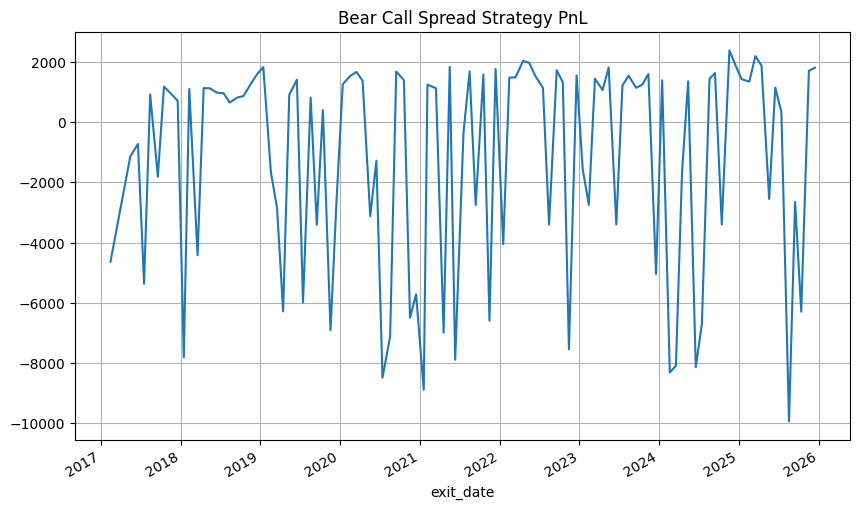

In [17]:
import matplotlib.pyplot as plt
results.set_index('exit_date')['pnl_amount'].plot(title='Bear Call Spread Strategy PnL', figsize=(10, 6))
plt.grid(True)
plt.show()

In [18]:
import pandas as pd
import numpy as np

# ... (保留原本的參數設定與 import) ...

def run_bear_call_spread_strategy_with_stop(df_opt, df_fut):
    """
    執行 Bear Call Spread 策略回測 (含觸價停損機制)
    策略：若 S > Short Strike，則強制平倉止損，當月不再進場。
    """
    print(f"=== 啟動回測 (含觸價停損): {START_DATE} 至 {END_DATE} ===")
    
    # 1. 資料與工具準備
    df_opt_clean = clean_options_data(df_opt)
    df_fut_clean = clean_futures_data(df_fut)
    
    rollover_map = build_rollover_map(
        df_fut_clean, START_DATE, END_DATE, offset=ROLLOVER_OFFSET
    )
    
    market_gen = market_data_generator(
        START_DATE, END_DATE, df_opt_clean, df_fut_clean, risk_free_rate=RISK_FREE_RATE
    )
    
    # 2. 狀態變數
    current_position = None 
    is_stopped_out = False  # 新增：標記當月是否已停損
    pnl_history = []
    
    # 3. 逐日回測
    for date, S, calls, puts in market_gen:
        
        # --- A. 停損監控 (Stop Loss Logic) ---
        # 只有在「持有部位」且「尚未停損」且「非換倉日(避免重複執行)」時檢查
        is_rollover, close_contract, open_contract = get_rollover_info(date, rollover_map)
        
        if current_position and not is_rollover:
            # 檢查條件：標的價格 S 是否漲破 Short Strike
            if S >= current_position['short_k']:
                print(f"[停損觸發] {date.date()} S={S:.0f} >= K={current_position['short_k']}")
                
                # 執行平倉
                try:
                    # 篩選當前合約報價
                    df_curr = calls[calls['到期月份(週別)'] == current_position['contract']]
                    
                    # 取得平倉價格
                    row_short = df_curr[df_curr['履約價'] == current_position['short_k']].iloc[0]
                    row_long  = df_curr[df_curr['履約價'] == current_position['long_k']].iloc[0]
                    
                    price_short_exit = row_short['收盤價']
                    price_long_exit  = row_long['收盤價']
                    
                    # 計算損益
                    exit_debit = price_short_exit - price_long_exit
                    pnl_points = current_position['entry_credit'] - exit_debit
                    
                    pnl_history.append({
                        'entry_date': current_position['entry_date'],
                        'exit_date': date,
                        'contract': current_position['contract'],
                        'S_entry': current_position['S_entry'],
                        'S_exit': S,
                        'short_k': current_position['short_k'],
                        'long_k': current_position['long_k'],
                        'entry_credit': current_position['entry_credit'],
                        'exit_debit': exit_debit,
                        'pnl_points': pnl_points,
                        'pnl_amount': pnl_points * MULTIPLIER,
                        'note': 'Stop Loss (Touch Strike)'
                    })
                    
                    # 更新狀態：清空部位，並標記已停損
                    current_position = None
                    is_stopped_out = True
                    
                except Exception as e:
                    print(f"[Error] {date.date()} 停損平倉失敗: {e}")
                    # 若失敗，可能因資料缺失，只好被迫留到下次處理
                    pass

        # --- B. 換倉日邏輯 (Rollover Logic) ---
        if is_rollover:
            # 1. 如果手上還有部位 (代表沒被停損)，正常結算平倉
            if current_position:
                if current_position['contract'] == close_contract:
                    try:
                        df_close = calls[calls['到期月份(週別)'] == close_contract]
                        price_short_exit = df_close[df_close['履約價'] == current_position['short_k']].iloc[0]['收盤價']
                        price_long_exit  = df_close[df_close['履約價'] == current_position['long_k']].iloc[0]['收盤價']
                        
                        exit_debit = price_short_exit - price_long_exit
                        pnl_points = current_position['entry_credit'] - exit_debit
                        
                        pnl_history.append({
                            'entry_date': current_position['entry_date'],
                            'exit_date': date,
                            'contract': current_position['contract'],
                            'S_entry': current_position['S_entry'],
                            'S_exit': S,
                            'short_k': current_position['short_k'],
                            'long_k': current_position['long_k'],
                            'entry_credit': current_position['entry_credit'],
                            'exit_debit': exit_debit,
                            'pnl_points': pnl_points,
                            'pnl_amount': pnl_points * MULTIPLIER,
                            'note': 'Normal Rollover'
                        })
                        current_position = None
                    except:
                        pass # 資料不足略過
            
            # 2. 建立新月份合約 (無論上個月是否停損，換倉日都視為新局開始)
            # 重置停損旗標
            is_stopped_out = False
            
            df_open = calls[calls['到期月份(週別)'] == open_contract]
            if not df_open.empty:
                valid_calls = df_open[df_open['Delta'] > 0].copy()
                if not valid_calls.empty:
                    # 找 Delta ~ 0.2
                    best_idx = (valid_calls['Delta'] - TARGET_DELTA).abs().idxmin()
                    short_leg = valid_calls.loc[best_idx]
                    k_short = short_leg['履約價']
                    k_long = k_short + FIX_WIDTH
                    
                    long_leg_df = df_open[df_open['履約價'] == k_long]
                    if not long_leg_df.empty:
                        long_leg = long_leg_df.iloc[0]
                        price_short = short_leg['收盤價']
                        price_long = long_leg['收盤價']
                        entry_credit = price_short - price_long
                        
                        current_position = {
                            'entry_date': date,
                            'contract': open_contract,
                            'short_k': k_short,
                            'long_k': k_long,
                            'entry_credit': entry_credit,
                            'S_entry': S,
                            'delta_at_open': short_leg['Delta']
                        }

    # 4. 整理結果
    df_result = pd.DataFrame(pnl_history)
    if not df_result.empty:
        df_result['cum_pnl'] = df_result['pnl_amount'].cumsum()
    
    return df_result

# ==========================================
# 執行與比較
# ==========================================
if 'df_opt' in locals() and 'df_fut' in locals():
    # 執行帶停損的版本
    results_stop = run_bear_call_spread_strategy_with_stop(df_opt, df_fut)
    
    if not results_stop.empty:
        print("\n" + "="*40)
        print("【含觸價停損機制】回測結果")
        print("="*40)
        print(f"總損益金額 : {results_stop['pnl_amount'].sum():,.0f} 元")
        print(f"交易次數   : {len(results_stop)}")
        print(f"最大回檔   : {(results_stop['cum_pnl'].cummax() - results_stop['cum_pnl']).max():,.0f} 元")
        
        # 觀察停損發生的次數
        stop_count = len(results_stop[results_stop['note'].str.contains('Stop Loss')])
        print(f"觸發停損次數: {stop_count} 次")
        print("="*40)

=== 啟動回測 (含觸價停損): 2001-12-24 至 2025-12-31 ===
--- 開始清洗選擇權資料 (Options) ---
>> 已過濾盤後資料: 2317932 筆
>> 選擇權資料清洗完成，共 1529628 筆。
--- 開始清洗期貨資料 (Futures) ---
>> 已排除價差單: 36798 筆
>> 期貨資料清洗完成，共 44990 筆。
--- 建立換倉日曆 (Offset=3) ---
>> 換倉日曆建立完成，共 290 個換倉點。
--- 初始化市場資料生成器 (2001-12-24 to 2025-12-31) ---
>> 預計執行交易日數: 5919 天
[停損觸發] 2017-02-10 S=9600 >= K=9600.0
[停損觸發] 2017-06-06 S=10202 >= K=10200.0
[停損觸發] 2017-06-21 S=10321 >= K=10300.0
[停損觸發] 2018-01-03 S=10748 >= K=10700.0
[停損觸發] 2018-01-23 S=11241 >= K=11200.0
[停損觸發] 2018-03-09 S=10906 >= K=10900.0
[停損觸發] 2019-02-13 S=10125 >= K=10100.0
[停損觸發] 2019-04-08 S=10779 >= K=10700.0
[停損觸發] 2019-07-01 S=10707 >= K=10700.0
[停損觸發] 2019-09-09 S=10802 >= K=10800.0
[停損觸發] 2019-11-04 S=11416 >= K=11400.0
[停損觸發] 2019-12-13 S=11977 >= K=11900.0
[停損觸發] 2020-04-30 S=10813 >= K=10700.0
[停損觸發] 2020-06-04 S=11419 >= K=11300.0
[停損觸發] 2020-07-06 S=11921 >= K=11800.0
[停損觸發] 2020-07-28 S=12834 >= K=12700.0
[停損觸發] 2020-12-04 S=14022 >= K=14000.0
[停損觸發] 2021-01-05 S=14874 >= K=1

In [19]:
results_stop

,entry_date,exit_date,contract,S_entry,S_exit,short_k,long_k,entry_credit,exit_debit,pnl_points,pnl_amount,note,cum_pnl
0,2017-01-16,2017-02-10,201702,9360.0,9600.0,9600.0,9800.0,13.5,70.0,-56.5,-2825.0,Stop Loss (Touch Strike),-2825.0
1,2017-04-17,2017-05-15,201705,9740.0,9990.0,10000.0,10200.0,19.3,41.9,-22.6,-1130.0,Normal Rollover,-3955.0
2,2017-05-15,2017-06-06,201706,9990.0,10202.0,10200.0,10400.0,35.0,51.4,-16.4,-820.0,Stop Loss (Touch Strike),-4775.0
3,2017-06-19,2017-06-21,201707,10147.0,10321.0,10300.0,10500.0,19.0,38.0,-19.0,-950.0,Stop Loss (Touch Strike),-5725.0
4,2017-07-17,2017-08-14,201708,10403.0,10311.0,10600.0,10800.0,19.0,0.4,18.6,930.0,Normal Rollover,-4795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2025-07-14,2025-08-08,202508,22670.0,24091.0,23700.0,23900.0,26.0,136.0,-110.0,-5500.0,Stop Loss (Touch Strike),-72525.0
101,2025-08-18,2025-09-11,202509,24199.0,25386.0,25300.0,25500.0,37.0,79.0,-42.0,-2100.0,Stop Loss (Touch Strike),-74625.0
102,2025-09-15,2025-10-02,202510,25404.0,26459.0,26400.0,26600.0,36.0,98.0,-62.0,-3100.0,Stop Loss (Touch Strike),-77725.0
103,2025-10-13,2025-10-30,202511,26450.0,28430.0,28400.0,28600.0,35.0,92.0,-57.0,-2850.0,Stop Loss (Touch Strike),-80575.0
